Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Train on 760 samples, validate on 360 samples
Epoch 1/200





760/760 [==============================] - 1s 844us/step - loss: 0.1540 - val_loss: 0.0421
Epoch 2/200
760/760 [==============================] - 0s 57us/step - loss: 0.0678 - val_loss: 0.0260
Epoch 3/200
760/760 [==============================] - 0s 61us/step - loss: 0.0495 - val_loss: 0.0226
Epoch 4/200
760/760 [==============================] - 0s 57us/step - loss: 0.0467 - val_loss: 0.0344
Epoch 5/200
760/760 [==============================] - 0s 58us/step - loss: 0.0411 - val_loss: 0.0337
Epoch 6/200
760/760 [==============================] - 0s 54us/step - loss: 0.0317 - val_loss: 0.0183
Epoch 7/200
760/760 [==============================] - 0s 58us/step - loss: 0.0320 - val_loss: 0.0234
Epoch 8/200
760/760 [==============================] - 0s 65us/step - loss: 0.0278 - val_loss: 0.0259
Epoch 9/2

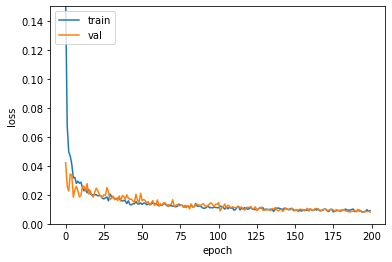

Train Score:  0.007884409121776882
Validation Score 0.007998021650645467
Test Score:  0.007998021650645467


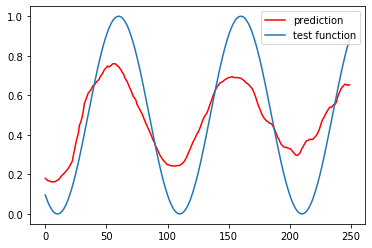

In [1]:
# 시계열 수치 입력 수치예측 모델 레시피
# 다층 퍼셉트론 모델

######### 1) 데이터셋 준비 #########
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


# 데이터셋 (데이터+라벨) 생성
# 데이터: 이전 수치, 라벨: 다음 수치
def create_dataset(signal_data,look_back=1):
    dataX, dataY=[],[]
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back),0])
        dataY.append(signal_data[i+look_back,0])
    return np.array(dataX), np.array(dataY)


#이전 40개의 수치를 입력하여 다음 수치 1개를 예측하기위해 40으로 설정
look_back=40

# 시간의 흐름에 따라 진폭이 -1~1사이로 변하는 1600개의 실수값을 생성
signal_data=np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]

# 데이터 전처리
# -1~1까지의 값을 가지는 코사인 데이터를 0~1 사이의 값을 가지도록 정규화
scaler=MinMaxScaler(feature_range=(0,1))
signal_data=scaler.fit_transform(signal_data)

# 데이터 분리
train=signal_data[0:800]
val=signal_data[800:1200]
test=signal_data[1200:]

#데이터셋 생성
x_train, y_train=create_dataset(train,look_back)
x_val, y_val=create_dataset(val,look_back)
x_test, y_test=create_dataset(test,look_back)

# 데이터셋 전처리
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_val=np.reshape(x_val,(x_val.shape[0],x_val.shape[1],1))
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

x_train=np.squeeze(x_train)
x_val=np.squeeze(x_val)
x_test=np.squeeze(x_test)


######### 2) 다층 퍼셉트론 모델 ##########
# Dense 레이어가 4개인 다층 퍼셉트론 모델
# 은닉층 Dense: 32개의 뉴런 + relu
# 출력층 Dense: 1개의 뉴런 + 활성화 함수 없음

model=Sequential()
model.add(Dense(32,input_dim=40,activation="relu"))
model.add(Dropout(0.3))
for i in range(2):
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.3))
model.add(Dense(1))

######### (3) 모델 학습 과정 설정하기 ############
model.compile(loss='mean_squared_error',optimizer='adagrad')

######### (4) 모델 학습시키기 ###########
hist = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_val,y_val))

######### (5) 학습과정 살펴보기 ##########
plt.figure(1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0,0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left' )
plt.show()

######### (6) 모델 평가하기 ##########
trainScore=model.evaluate(x_train,y_train,verbose=0)
print('Train Score: ', trainScore)
valScore=model.evaluate(x_val,y_val,verbose=0)
print('Validation Score', valScore)
testScore=model.evaluate(x_test,y_test,verbose=0)
print('Test Score: ', testScore)

######### (7) 모델 사용하기 ##########
look_ahead = 250
xhat = x_test[0, None]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(xhat, batch_size=32)
    predictions[i] = prediction
    xhat = np.hstack([xhat[:,1:],prediction])

plt.figure(2)
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
plt.legend()
plt.show()